In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering

In [8]:
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
5,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
7,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [9]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [10]:
...

Ellipsis

## Making target

In [11]:
def pick_target(df, column='clinVarClinSignifs'):
    df = df.copy()
    df['y'] = df[column].astype(str).apply(lambda x: int('pathogenic' in x.lower()))
    del df[column]
    return df

In [12]:
df = pick_target(df)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,nOrthos,conservedOrthos,y
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,10.0,2.0,0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,NaN,NaN,1
4,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,NaN,NaN,1
5,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,NaN,NaN,1
7,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,10.0,2.0,0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    y = df.y
    del df['y']
    X = df
    cat_features = np.where(X.dtypes != np.float)[0]
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

In [14]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(151492, 37874, 47342)

## Run

In [15]:
model = CatBoostClassifier(iterations=500)

In [16]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate));

0:	learn: 0.6553990	test: 0.6554760	best: 0.6554760 (0)	total: 349ms	remaining: 2m 54s
1:	learn: 0.6189293	test: 0.6189353	best: 0.6189353 (1)	total: 653ms	remaining: 2m 42s
2:	learn: 0.5926003	test: 0.5926099	best: 0.5926099 (2)	total: 889ms	remaining: 2m 27s
3:	learn: 0.5684175	test: 0.5683813	best: 0.5683813 (3)	total: 1.19s	remaining: 2m 27s
4:	learn: 0.5470915	test: 0.5470285	best: 0.5470285 (4)	total: 1.4s	remaining: 2m 18s
5:	learn: 0.5203627	test: 0.5203328	best: 0.5203328 (5)	total: 1.78s	remaining: 2m 26s
6:	learn: 0.5004092	test: 0.5001929	best: 0.5001929 (6)	total: 2.16s	remaining: 2m 32s
7:	learn: 0.4817523	test: 0.4813775	best: 0.4813775 (7)	total: 2.5s	remaining: 2m 33s
8:	learn: 0.4652153	test: 0.4647065	best: 0.4647065 (8)	total: 2.85s	remaining: 2m 35s
9:	learn: 0.4509523	test: 0.4503646	best: 0.4503646 (9)	total: 3.19s	remaining: 2m 36s
10:	learn: 0.4364355	test: 0.4357816	best: 0.4357816 (10)	total: 3.61s	remaining: 2m 40s
11:	learn: 0.4224559	test: 0.4216878	best: 

93:	learn: 0.1829195	test: 0.1718645	best: 0.1718645 (93)	total: 31.5s	remaining: 2m 15s
94:	learn: 0.1826723	test: 0.1716193	best: 0.1716193 (94)	total: 31.8s	remaining: 2m 15s
95:	learn: 0.1822949	test: 0.1712862	best: 0.1712862 (95)	total: 32.2s	remaining: 2m 15s
96:	learn: 0.1820185	test: 0.1710499	best: 0.1710499 (96)	total: 32.6s	remaining: 2m 15s
97:	learn: 0.1818831	test: 0.1709032	best: 0.1709032 (97)	total: 33s	remaining: 2m 15s
98:	learn: 0.1816117	test: 0.1706775	best: 0.1706775 (98)	total: 33.4s	remaining: 2m 15s
99:	learn: 0.1814415	test: 0.1705007	best: 0.1705007 (99)	total: 33.8s	remaining: 2m 15s
100:	learn: 0.1811893	test: 0.1702799	best: 0.1702799 (100)	total: 34.2s	remaining: 2m 15s
101:	learn: 0.1810359	test: 0.1701245	best: 0.1701245 (101)	total: 34.6s	remaining: 2m 15s
102:	learn: 0.1806780	test: 0.1698272	best: 0.1698272 (102)	total: 35s	remaining: 2m 14s
103:	learn: 0.1805271	test: 0.1696950	best: 0.1696950 (103)	total: 35.3s	remaining: 2m 14s
104:	learn: 0.180

184:	learn: 0.1714128	test: 0.1610667	best: 0.1610667 (184)	total: 1m 3s	remaining: 1m 48s
185:	learn: 0.1713291	test: 0.1609826	best: 0.1609826 (185)	total: 1m 4s	remaining: 1m 48s
186:	learn: 0.1712446	test: 0.1608827	best: 0.1608827 (186)	total: 1m 4s	remaining: 1m 48s
187:	learn: 0.1711844	test: 0.1607983	best: 0.1607983 (187)	total: 1m 5s	remaining: 1m 48s
188:	learn: 0.1711133	test: 0.1607267	best: 0.1607267 (188)	total: 1m 5s	remaining: 1m 48s
189:	learn: 0.1710794	test: 0.1607048	best: 0.1607048 (189)	total: 1m 6s	remaining: 1m 48s
190:	learn: 0.1710276	test: 0.1606613	best: 0.1606613 (190)	total: 1m 6s	remaining: 1m 48s
191:	learn: 0.1709672	test: 0.1606177	best: 0.1606177 (191)	total: 1m 7s	remaining: 1m 47s
192:	learn: 0.1709232	test: 0.1605818	best: 0.1605818 (192)	total: 1m 7s	remaining: 1m 47s
193:	learn: 0.1708563	test: 0.1605108	best: 0.1605108 (193)	total: 1m 8s	remaining: 1m 47s
194:	learn: 0.1707869	test: 0.1604266	best: 0.1604266 (194)	total: 1m 8s	remaining: 1m 47s

274:	learn: 0.1670418	test: 0.1571883	best: 0.1571883 (274)	total: 1m 42s	remaining: 1m 23s
275:	learn: 0.1670095	test: 0.1571485	best: 0.1571485 (275)	total: 1m 42s	remaining: 1m 23s
276:	learn: 0.1669823	test: 0.1571332	best: 0.1571332 (276)	total: 1m 42s	remaining: 1m 22s
277:	learn: 0.1669573	test: 0.1570972	best: 0.1570972 (277)	total: 1m 43s	remaining: 1m 22s
278:	learn: 0.1669039	test: 0.1570407	best: 0.1570407 (278)	total: 1m 43s	remaining: 1m 22s
279:	learn: 0.1668743	test: 0.1570199	best: 0.1570199 (279)	total: 1m 43s	remaining: 1m 21s
280:	learn: 0.1668235	test: 0.1569772	best: 0.1569772 (280)	total: 1m 44s	remaining: 1m 21s
281:	learn: 0.1667982	test: 0.1569692	best: 0.1569692 (281)	total: 1m 44s	remaining: 1m 20s
282:	learn: 0.1667754	test: 0.1569522	best: 0.1569522 (282)	total: 1m 45s	remaining: 1m 20s
283:	learn: 0.1667527	test: 0.1569389	best: 0.1569389 (283)	total: 1m 45s	remaining: 1m 20s
284:	learn: 0.1667364	test: 0.1569316	best: 0.1569316 (284)	total: 1m 45s	remain

365:	learn: 0.1645262	test: 0.1551568	best: 0.1551568 (365)	total: 2m 14s	remaining: 49.3s
366:	learn: 0.1645029	test: 0.1551387	best: 0.1551387 (366)	total: 2m 14s	remaining: 48.9s
367:	learn: 0.1644792	test: 0.1551200	best: 0.1551200 (367)	total: 2m 15s	remaining: 48.5s
368:	learn: 0.1644706	test: 0.1551113	best: 0.1551113 (368)	total: 2m 15s	remaining: 48.2s
369:	learn: 0.1644525	test: 0.1550963	best: 0.1550963 (369)	total: 2m 16s	remaining: 47.8s
370:	learn: 0.1644123	test: 0.1550761	best: 0.1550761 (370)	total: 2m 16s	remaining: 47.4s
371:	learn: 0.1644018	test: 0.1550697	best: 0.1550697 (371)	total: 2m 16s	remaining: 47.1s
372:	learn: 0.1643855	test: 0.1550605	best: 0.1550605 (372)	total: 2m 17s	remaining: 46.7s
373:	learn: 0.1643624	test: 0.1550401	best: 0.1550401 (373)	total: 2m 17s	remaining: 46.3s
374:	learn: 0.1643435	test: 0.1550188	best: 0.1550188 (374)	total: 2m 17s	remaining: 45.9s
375:	learn: 0.1643166	test: 0.1549993	best: 0.1549993 (375)	total: 2m 18s	remaining: 45.6s

456:	learn: 0.1626638	test: 0.1537965	best: 0.1537965 (456)	total: 2m 48s	remaining: 15.8s
457:	learn: 0.1626463	test: 0.1537867	best: 0.1537867 (457)	total: 2m 48s	remaining: 15.5s
458:	learn: 0.1626158	test: 0.1537622	best: 0.1537622 (458)	total: 2m 48s	remaining: 15.1s
459:	learn: 0.1625783	test: 0.1537367	best: 0.1537367 (459)	total: 2m 49s	remaining: 14.7s
460:	learn: 0.1625745	test: 0.1537355	best: 0.1537355 (460)	total: 2m 49s	remaining: 14.3s
461:	learn: 0.1625539	test: 0.1537055	best: 0.1537055 (461)	total: 2m 49s	remaining: 14s
462:	learn: 0.1625440	test: 0.1537022	best: 0.1537022 (462)	total: 2m 50s	remaining: 13.6s
463:	learn: 0.1625162	test: 0.1536842	best: 0.1536842 (463)	total: 2m 50s	remaining: 13.2s
464:	learn: 0.1624952	test: 0.1536663	best: 0.1536663 (464)	total: 2m 51s	remaining: 12.9s
465:	learn: 0.1624788	test: 0.1536482	best: 0.1536482 (465)	total: 2m 51s	remaining: 12.5s
466:	learn: 0.1624692	test: 0.1536397	best: 0.1536397 (466)	total: 2m 51s	remaining: 12.1s
4

In [17]:
y_pred = model.predict(X_test)
(y_pred == y_test).sum() / len(y_test)

0.9395251573655528

In [18]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

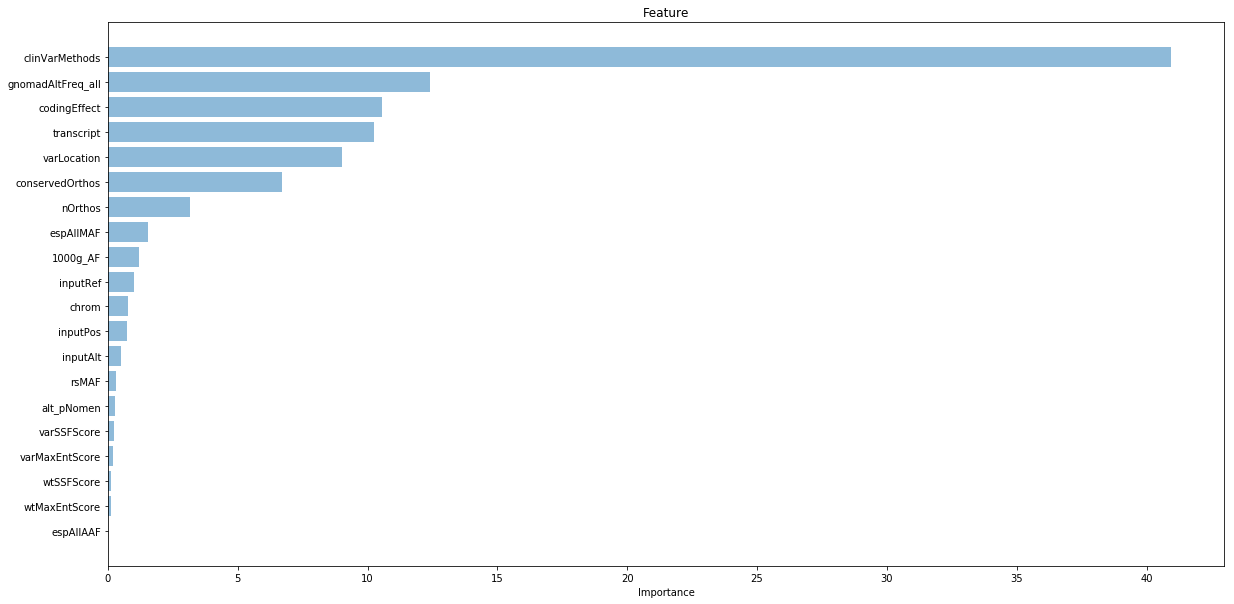

In [19]:
draw_importance(X_train.columns, model.feature_importances_)